In [1]:
import json
import os
import shutil
import sys
from argparse import ArgumentParser
from collections import deque
# from d4rl.pointmaze.maze_model import LARGE_OPEN
from IPython.display import display, Markdown, Latex
from copy import copy, deepcopy

import h5py
from tqdm import tqdm
from matplotlib import cm
from torch.utils.tensorboard import SummaryWriter
import torch
import numpy as np
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
import random
import matplotlib.colors as mcolors

from nav2d_representation.models import SingleStep, MultiStep
from nav2d_representation.nav2d.nav2d import Navigate2D

np.set_printoptions(threshold=10000)
import torch.nn.functional as F
import random
from nav2d_representation.utils import ENV_DICT
from nav2d_representation.nav2d.utils import perturb_heatmap, return_encoded_vector

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

def distance_measure(embed1, embed2, order=2):
    return np.linalg.norm((embed1-embed2).flatten(), ord=order)

def fpl(pos, rs, cs): # find pattern location
    return np.array([pos[0] % rs, pos[1] % cs])


def normalize(vec):
    return (vec - np.min(vec)) / (np.max(vec) - np.min(vec))

def find_pattern_distance(pos1, pos2, row_stride, col_stride, order=2):
    diff = pos1 - pos2
    diff[0] = diff[0] % row_stride
    diff[1] = diff[1] % col_stride
    return np.linalg.norm(diff,ord=order)

default_model_gamma_0_9/embeddings/size_vary.hdf5
['inner_static_outer_diff_7', 'inner_diff_outer_static_7', 'inner_static_outer_diff_5', 'inner_diff_outer_static_5', 'inner_diff_outer_static_3', 'inner_static_outer_diff_3']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:02<00:00, 196.41it/s]


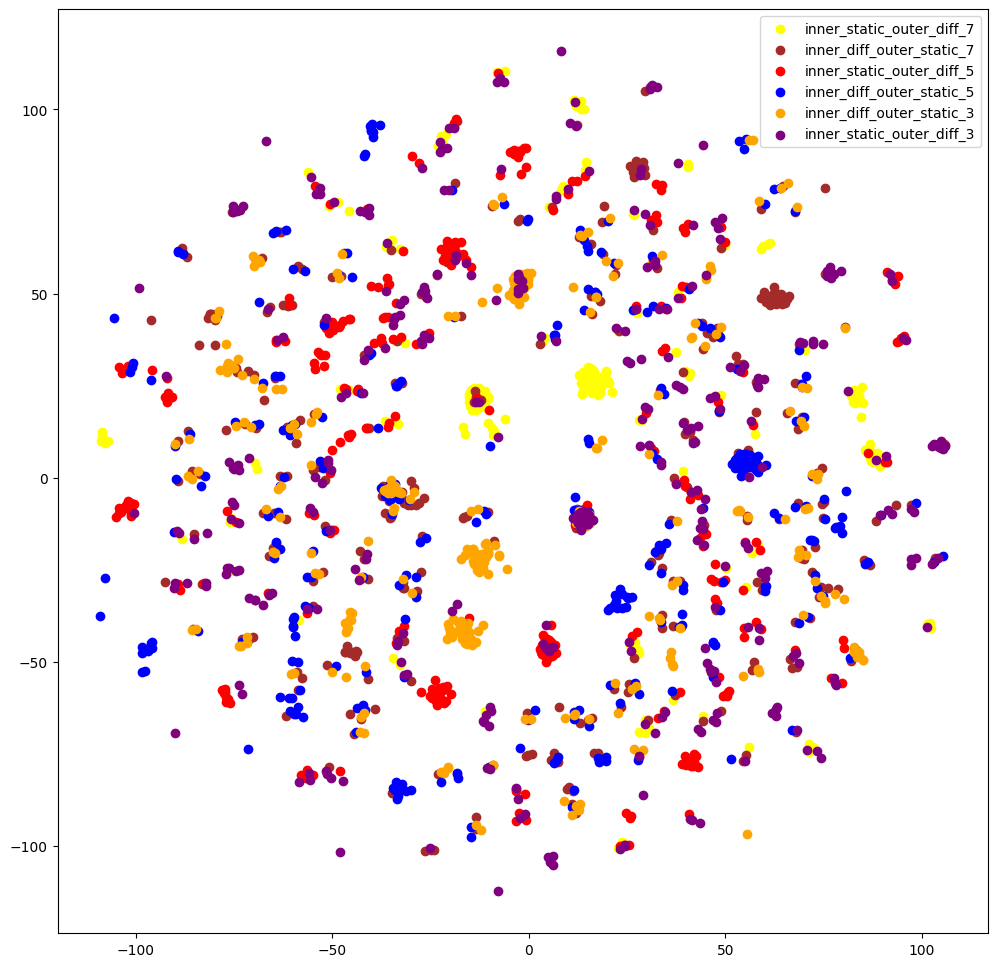

In [7]:
ssd = []
msd = []
pod = []
pad = []

model_name = 'default_model_gamma_0_9'
file_name = 'size_vary.hdf5'


datadir = model_name + '/embeddings' 

try:
    dataset.close()
except:
    pass

print(datadir + '/' + file_name)
dataset = h5py.File(datadir + '/' + file_name, "r")
dataset_keys = []
dataset.visit(
    lambda key: dataset_keys.append(key)
    if isinstance(dataset[key], h5py.Dataset)
    else None
)

pattern_names = [name.decode("utf-8") for name in list(set(dataset['name']))]
pattern_names = pattern_names
labels = [name.decode("utf-8") for name in dataset['name']]
print(pattern_names)

results_dict = {}

# pattern_names = ['outer_static_inner_diff', 'outer_diff_inner_empty', 'outer_diff_inner_diff', 'corridor']

for pattern_name in pattern_names:


    num_embeddings = len(dataset['obs'])
    pos_dists = [] 
    multi_step_dists = []
    single_step_dists = []
    embed_dist = [] 
    pattern_dists = []
    count = 0
    norm_orders = [1]


    outer_diffs_single = []
    outer_diffs_multi = []
    inner_diffs_single = []
    inner_diffs_multi = []
    
    dlen = len(dataset['name'])
    
    ss_encs = [dataset['ss_enc'][i] for i in range(dlen) if dataset['name'][i].decode("utf-8") == pattern_name]
    ms_encs = [dataset['ms_enc'][i] for i in range(dlen) if dataset['name'][i].decode("utf-8") == pattern_name]
    poss = [dataset['pos'][i] for i in range(dlen) if dataset['name'][i].decode("utf-8") == pattern_name]
    inner_obss = [dataset['inner_obs'][i] for i in range(dlen) if dataset['name'][i].decode("utf-8") == pattern_name]
    obss = [dataset['obs'][i] for i in range(dlen) if dataset['name'][i].decode("utf-8") == pattern_name]
    
    nlen = len(ss_encs)
    
    
    count = 0
    for i in tqdm(range(nlen)):
        for j in range(i+1, nlen):
            
            single_step_dist = distance_measure(ss_encs[i], ss_encs[j], order=2)
            multi_step_dist =  distance_measure(ms_encs[i], ms_encs[j], order=2)

            pos_dist = distance_measure(poss[i], poss[j], order=2)
            pattern_dist = distance_measure(obss[i], obss[j], order=1)
            
            single_step_dists.append(single_step_dist)
            multi_step_dists.append(multi_step_dist)
            pos_dists.append(pos_dist)
            pattern_dists.append(pattern_dist)
                
                
    
                


    results_dict[pattern_name]= {'ssd': single_step_dists,
                                           'msd': multi_step_dists,
                                           'pod': pos_dists,
                                           'pad': pattern_dists,
                                           'obs': np.array(obss[:]),
                                           'ss_enc': ss_encs[:],
                                           'ms_enc': ms_encs[:] }
    
ms_encs = np.array([dataset['ss_enc'][i] for i in range(dlen)])
labels = [dataset['name'][i].decode("utf-8") for i in range(dlen)]

X = ms_encs #np.array(results_dict['outer_diff_inner_empty']['msd'])

X_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=3).fit_transform(X)
X_embedded += np.random.normal(0, 1, size=X_embedded.shape)
plt.rcParams["figure.figsize"] = (12,12)
mask = np.array([pattern_names.index(pat.decode("utf-8")) for pat in dataset['name']])
total_colors =  ['yellow', 'red', 'blue', 'green', 'purple', 'orange', 'black', 'brown'] #list(mcolors.CSS4_COLORS)
colors = random.sample(total_colors, len(pattern_names))

for p in range(len(pattern_names)):
    plt.scatter(X_embedded[mask==p,0], X_embedded[mask==p,1], c = colors[p], label=pattern_names[p])
    plt.legend()
dataset.close()

<Figure size 1500x300 with 0 Axes>

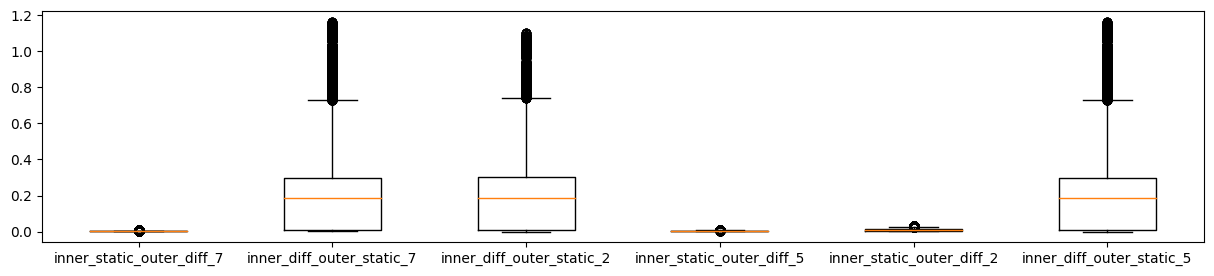

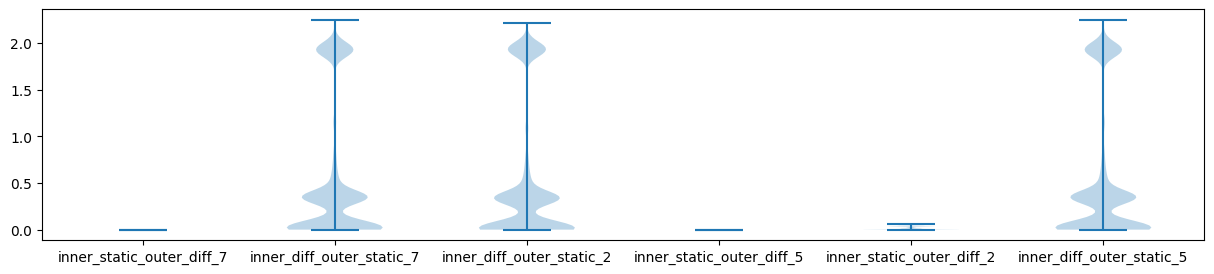

<Figure size 1500x300 with 0 Axes>

In [4]:
plt.rcParams["figure.figsize"] = (15,3)
msd = [results_dict[pattern_name]['msd'] for pattern_name in pattern_names]
ssd = [results_dict[pattern_name]['ssd'] for pattern_name in pattern_names]
fig = plt.boxplot(msd)
plt.xticks([i+1 for i in range(len(pattern_names))], pattern_names)
plt.figure()

plt.violinplot(ssd)
plt.xticks([i+1 for i in range(len(pattern_names))], pattern_names)
plt.figure()


(400, 3, 20, 20)
(400, 3, 20, 20)
(400, 3, 20, 20)
(400, 3, 20, 20)
(400, 3, 20, 20)
(400, 3, 20, 20)


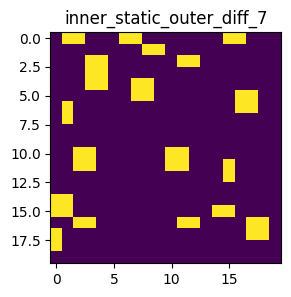

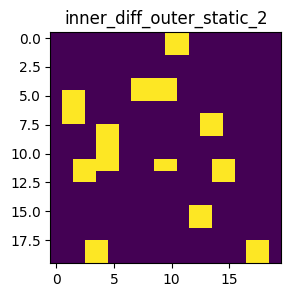

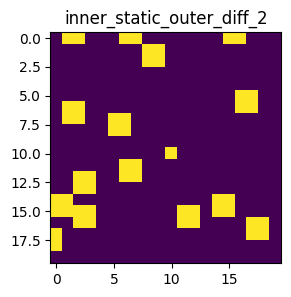

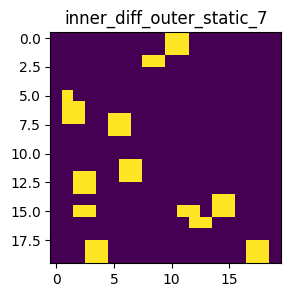

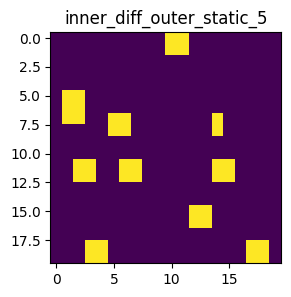

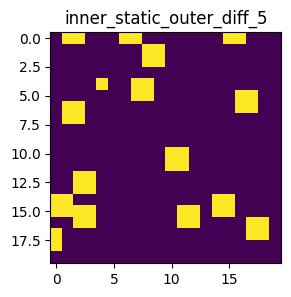

<Figure size 1500x300 with 0 Axes>

In [53]:
pattern_names
results_dict.keys()
for pattern_name in pattern_names:
    print(results_dict[pattern_name]['obs'].shape)
    plt.imshow(results_dict[pattern_name]['obs'][9,0,:,:])
    plt.title(pattern_name)
    plt.figure()

In [19]:
try:
    dataset.close()
except:
    print('excepted')


In [65]:
def calc_single_obj_distance(file_names=['empty_single.hdf5'], model_name=None, results_dict=None):

    ssd = []
    msd = []
    pod = []
    pad = []
    results_dict[model_name] = {}
    
    datadir = model_name + '/embeddings' #input("What file, baby?\n")
    
    for file_name in file_names:
        try:
            dataset.close()
        except:
            pass
        
        print(datadir + '/' + file_name)
        dataset = h5py.File(datadir + '/' + file_name, "r")
        dataset_keys = []
        dataset.visit(
            lambda key: dataset_keys.append(key)
            if isinstance(dataset[key], h5py.Dataset)
            else None
        )


        num_embeddings = len(dataset['obs'])
        pos_dists = [] 
        multi_step_dists = []
        single_step_dists = []
        embed_dist = [] 
        pattern_dists = []
        count = 0
        models = ['ms_enc', 'ss_enc']
        norm_orders = [1]


        outer_diffs_single = []
        outer_diffs_multi = []
        inner_diffs_single = []
        inner_diffs_multi = []
        


        for i in tqdm(range(num_embeddings)):
            single_step_dist = distance_measure(dataset['ss_enc'][i], dataset['ss_enc'][j], order=1)
            multi_step_dist =  distance_measure(dataset['ms_enc'][i], dataset['ms_enc'][j], order=1)

            pos_dist = distance_measure(dataset['pos'][i], dataset['pos'][j], order=2)
            pattern_dist = distance_measure(dataset['inner_obs'][i], dataset['inner_obs'][j], order=1)

            single_step_dists.append(single_step_dist)
            multi_step_dists.append(multi_step_dist)
            pos_dists.append(pos_dist)
            pattern_dists.append(pattern_dist)
                
        results_dict[model_name][file_name] = {'ssd': single_step_dists,
                                               'msd': multi_step_dists,
                                               'pod': pos_dists,
                                               'pad': pattern_dists,
                                               'obs': dataset['obs'],
                                               'ss_enc': dataset['ss_enc'],
                                               'ms_enc': dataset['ms_enc'] }
    return results_dict.copy()    
    

def calc_pairwise_distances(file_names=None, model_name=None, results_dict=None):

    ssd = []
    msd = []
    pod = []
    pad = []
    results_dict[model_name] = {}
    
    datadir = model_name + '/embeddings' #input("What file, baby?\n")
    
    for file_name in file_names:
        print(file_name)
        print(file_names)
        try:
            dataset.close()
        except:
            pass
        
        print(datadir + '/' + file_name)
        dataset = h5py.File(datadir + '/' + file_name, "r")
        dataset_keys = []
        dataset.visit(
            lambda key: dataset_keys.append(key)
            if isinstance(dataset[key], h5py.Dataset)
            else None
        )


        num_embeddings = len(dataset['obs'])
        pos_dists = [] 
        multi_step_dists = []
        single_step_dists = []
        embed_dist = [] 
        pattern_dists = []
        count = 0
        models = ['ms_enc', 'ss_enc']
        norm_orders = [1]


        outer_diffs_single = []
        outer_diffs_multi = []
        inner_diffs_single = []
        inner_diffs_multi = []

        for i in tqdm(range(num_embeddings)):
            for j in range(i, num_embeddings):
                single_step_dist = distance_measure(dataset['ss_enc'][i], dataset['ss_enc'][j], order=1)
                multi_step_dist =  distance_measure(dataset['ms_enc'][i], dataset['ms_enc'][j], order=1)

                pos_dist = distance_measure(dataset['pos'][i], dataset['pos'][j], order=2)
                pattern_dist = distance_measure(dataset['inner_obs'][i], dataset['inner_obs'][j], order=1)

                single_step_dists.append(single_step_dist)
                multi_step_dists.append(multi_step_dist)
                pos_dists.append(pos_dist)
                pattern_dists.append(pattern_dist)
                
        results_dict[model_name][file_name] = {'ssd': single_step_dists,
                                               'msd': multi_step_dists,
                                               'pod': pos_dists,
                                               'pad': pattern_dists,
                                               'obs': dataset['obs'],
                                               'ss_enc': dataset['ss_enc'],
                                               'ms_enc': dataset['ms_enc'] }
    return results_dict.copy()


In [130]:

ssd = []
msd = []
pod = []
pad = []

results_dict = {}

pattern_names = ['outer_static_inner_diff', 'outer_diff_inner_empty', 'outer_diff_inner_diff', 'corridor']

for pattern_name in pattern_names:
    model_name = 'default_model_gamma_0_5'
    file_name = 'neurips_test.hdf5'
    results_dict[pattern_name] = {}

    datadir = model_name + '/embeddings' 

    try:
        dataset.close()
    except:
        pass

    print(datadir + '/' + file_name)
    dataset = h5py.File(datadir + '/' + file_name, "r")
    dataset_keys = []
    dataset.visit(
        lambda key: dataset_keys.append(key)
        if isinstance(dataset[key], h5py.Dataset)
        else None
    )


    num_embeddings = len(dataset['obs'])
    pos_dists = [] 
    multi_step_dists = []
    single_step_dists = []
    embed_dist = [] 
    pattern_dists = []
    count = 0
    norm_orders = [1]


    outer_diffs_single = []
    outer_diffs_multi = []
    inner_diffs_single = []
    inner_diffs_multi = []
    
    dlen = len(dataset['name'])

    labels = [name.decode("utf-8") for name in dataset['name']]
    
    ss_encs = [dataset['ss_enc'][i] for i in range(dlen) if dataset['name'][i].decode("utf-8") == pattern_name]
    ms_encs = [dataset['ms_enc'][i] for i in range(dlen) if dataset['name'][i].decode("utf-8") == pattern_name]
    poss = [dataset['pos'][i] for i in range(dlen) if dataset['name'][i].decode("utf-8") == pattern_name]
    inner_obss = [dataset['inner_obs'][i] for i in range(dlen) if dataset['name'][i].decode("utf-8") == pattern_name]
    obss = [dataset['obs'][i] for i in range(dlen) if dataset['name'][i].decode("utf-8") == pattern_name]
    
    nlen = len(ss_encs)
    
    
    count = 0
    for i in tqdm(range(nlen)):
        for j in range(i+1, nlen):
            
            single_step_dist = distance_measure(ss_encs[i], ss_encs[j], order=2)
            multi_step_dist =  distance_measure(ms_encs[i], ms_encs[j], order=2)

            pos_dist = distance_measure(poss[i], poss[j], order=2)
            pattern_dist = distance_measure(obss[i], obss[j], order=1)
            
            single_step_dists.append(single_step_dist)
            multi_step_dists.append(multi_step_dist)
            pos_dists.append(pos_dist)
            pattern_dists.append(pattern_dist)
                
                
    
                


    results_dict[pattern_name]= {'ssd': single_step_dists,
                                           'msd': multi_step_dists,
                                           'pod': pos_dists,
                                           'pad': pattern_dists,
                                           'obs': np.array(obss[:]),
                                           'ss_enc': ss_encs[:],
                                           'ms_enc': ms_encs[:] }
                                           

default_model_gamma_0_5/embeddings/neurips_test.hdf5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:02<00:00, 199.13it/s]


default_model_gamma_0_5/embeddings/neurips_test.hdf5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:02<00:00, 197.80it/s]


default_model_gamma_0_5/embeddings/neurips_test.hdf5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:01<00:00, 200.04it/s]


default_model_gamma_0_5/embeddings/neurips_test.hdf5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 184/184 [00:00<00:00, 440.70it/s]


In [101]:
ms_encs = np.array([dataset['ss_enc'][i] for i in range(dlen)])
labels = [dataset['name'][i].decode("utf-8") for i in range(dlen)]
print(ms_encs.shape)
X = ms_encs #np.array(results_dict['outer_diff_inner_empty']['msd'])

X_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=3).fit_transform(X)
X_embedded += np.random.normal(0, 1, size=X_embedded.shape)

(1384, 128)


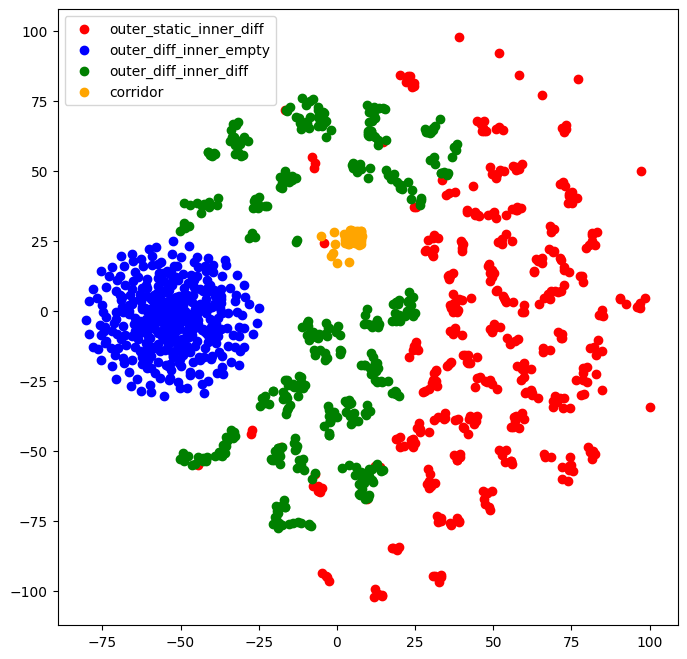

In [117]:
mask = np.array([pattern_names.index(pat.decode("utf-8")) for pat in dataset['name']])
colors = ['red', 'blue', 'green', 'orange']
for p in range(len(pattern_names)):
    plt.scatter(X_embedded[mask==p,0], X_embedded[mask==p,1], c = colors[p], label=pattern_names[p])
    plt.legend()

(400, 3, 20, 20)
(400, 3, 20, 20)
(400, 3, 20, 20)
(204, 3, 20, 20)


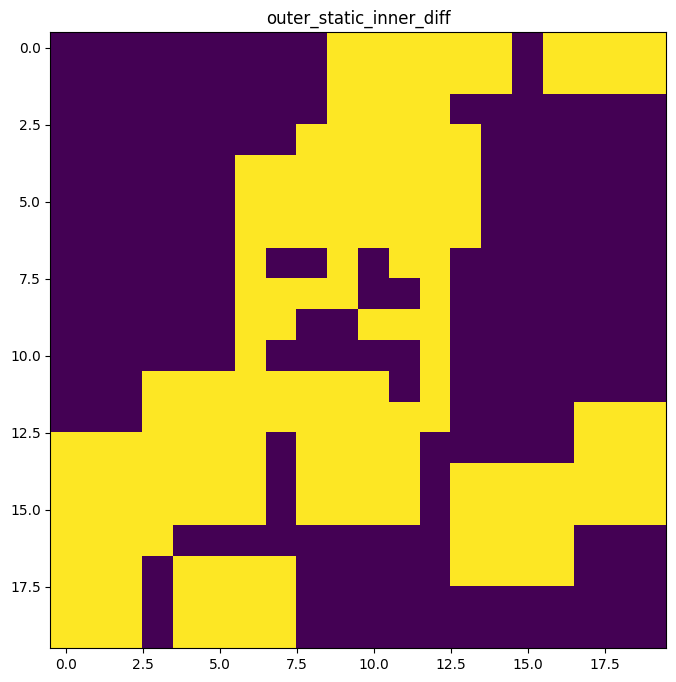

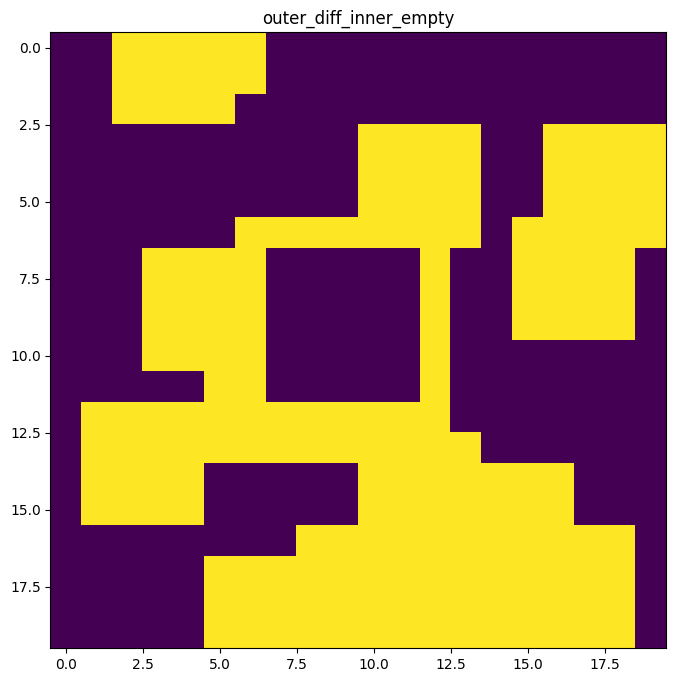

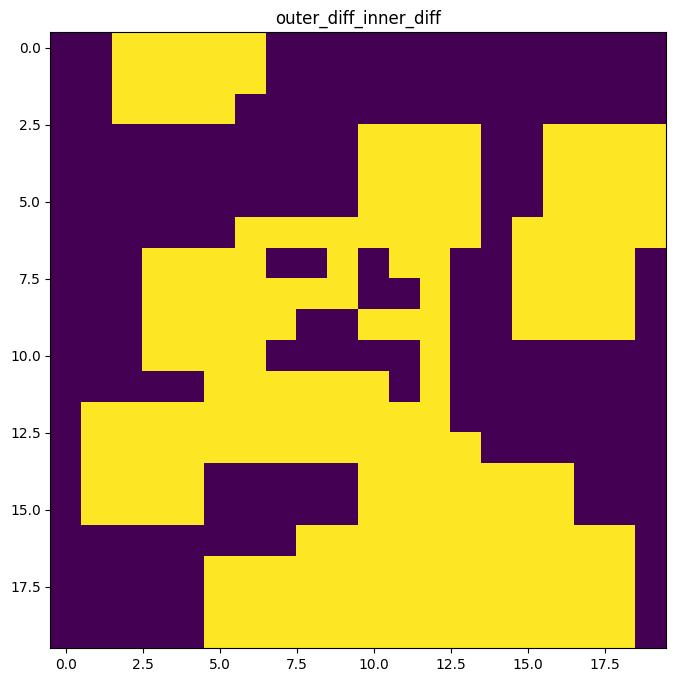

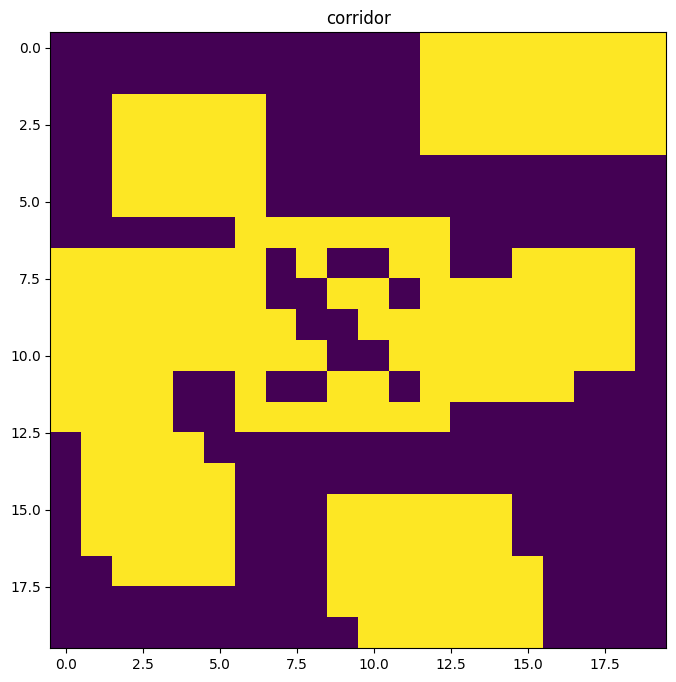

<Figure size 800x800 with 0 Axes>

In [128]:

pattern_names
results_dict.keys()
for pattern_name in pattern_names:
    print(results_dict[pattern_name]['obs'].shape)
    plt.imshow(results_dict[pattern_name]['obs'][9,0,:,:])
    plt.title(pattern_name)
    plt.figure()

<Figure size 1000x300 with 0 Axes>

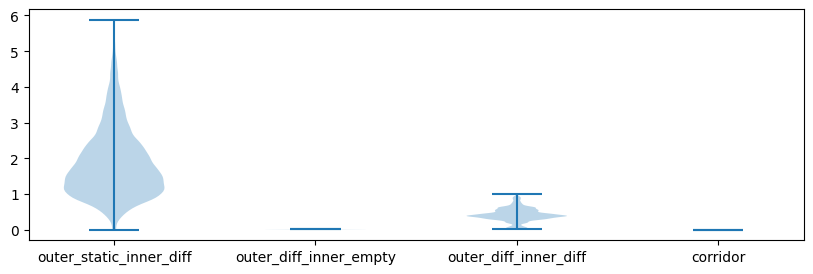

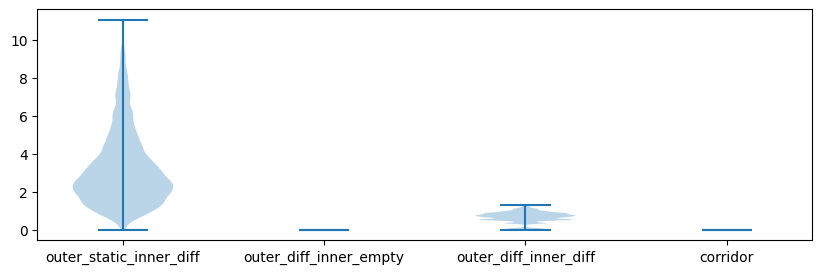

<Figure size 1000x300 with 0 Axes>

In [131]:
plt.rcParams["figure.figsize"] = (10,3)
msd = [results_dict[pattern_name]['msd'] for pattern_name in pattern_names]
ssd = [results_dict[pattern_name]['ssd'] for pattern_name in pattern_names]
fig = plt.violinplot(msd)
plt.xticks([i+1 for i in range(len(pattern_names))], pattern_names)
plt.figure()

plt.violinplot(ssd)
plt.xticks([i+1 for i in range(len(pattern_names))], pattern_names)
plt.figure()


0.0026547126
[9 9]
0.001015141
[9 9]


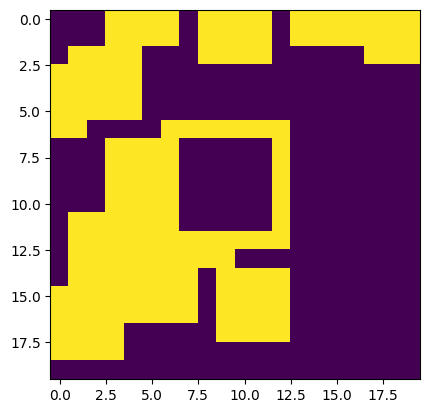

In [34]:
i = 230
j = 220
plt.imshow(dataset['obs'][i][0, :, :])
print(multi_step_dists[i])
print(dataset['pos'][i])
plt.imshow(dataset['obs'][j][0, :, :])
print(multi_step_dists[j])
print(dataset['pos'][j])


In [19]:
dataset.close()

In [26]:

model_name = 'random_start_model_gamma_0_5'
datadir = model_name + '/embeddings' #input("What file, baby?\n")
file_name = 'none_single.hdf5'

try:
    dataset.close()
except:
    pass

print(datadir + '/' + file_name)
dataset = h5py.File(datadir + '/' + file_name, "r")
dataset_keys = []
dataset.visit(
    lambda key: dataset_keys.append(key)
    if isinstance(dataset[key], h5py.Dataset)
    else None
)

single_step_dists = []
multi_step_dists = []
pos_dists = []
obs_diffs = []
base_obs_idx = np.argmin([np.sum(ob[0,:,:][:]) for ob in dataset['obs']])
#base_obs = dataset['obs'][base_obs_idx][0,:,:]
print(base_obs_idx)
# print(base_obs)
idx = np.array(np.unravel_index(np.arange(400), (20,20)))

for j in range( len(dataset['obs'])):
    
    single_step_dist = distance_measure(dataset['ss_enc'][j], dataset['ss_enc'][base_obs_idx], order=1)
    multi_step_dist =  distance_measure(dataset['ms_enc'][j], dataset['ms_enc'][base_obs_idx], order=1)
    pos_dist = np.linalg.norm(np.array([9,9]) - idx[:,j] )

    obs_diffs.append(distance_measure(dataset['obs'][j][0,:,:], dataset['obs'][base_obs_idx][0,:,:], order=2))
    single_step_dists.append(single_step_dist)
    multi_step_dists.append(multi_step_dist)
    pos_dists.append(pos_dist)




random_start_model_gamma_0_5/embeddings/none_single.hdf5
6


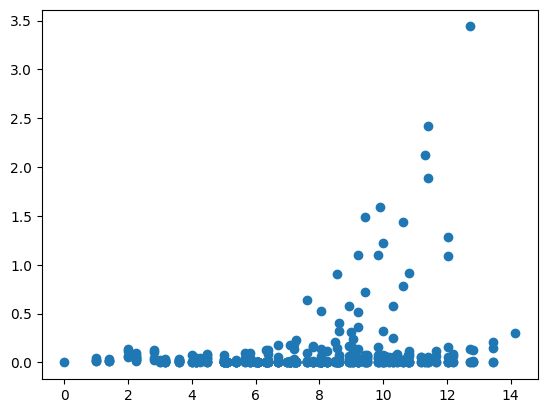

In [27]:

plt.scatter(pos_dists, multi_step_dists)


default_model_gamma_0_5/embeddings/neurips_test.hdf5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:02<00:00, 197.88it/s]


default_model_gamma_0_5/embeddings/neurips_test.hdf5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:02<00:00, 198.16it/s]


default_model_gamma_0_5/embeddings/neurips_test.hdf5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:02<00:00, 195.72it/s]


default_model_gamma_0_5/embeddings/neurips_test.hdf5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 184/184 [00:00<00:00, 431.66it/s]


(1384, 128)


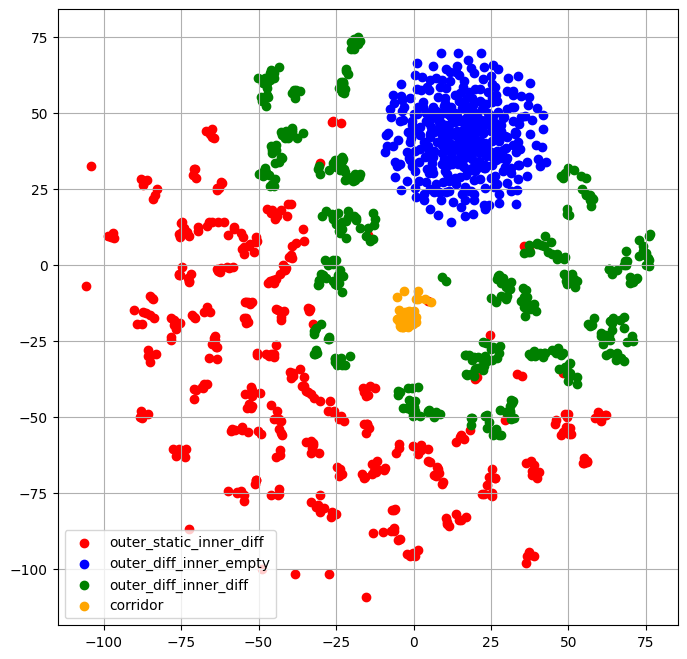

In [124]:
ssd = []
msd = []
pod = []
pad = []

results_dict = {}

pattern_names = ['outer_static_inner_diff', 'outer_diff_inner_empty', 'outer_diff_inner_diff', 'corridor']

for pattern_name in pattern_names:
    model_name = 'default_model_gamma_0_5'
    file_name = 'neurips_test.hdf5'
    results_dict[pattern_name] = {}

    datadir = model_name + '/embeddings' 

    try:
        dataset.close()
    except:
        pass

    print(datadir + '/' + file_name)
    dataset = h5py.File(datadir + '/' + file_name, "r")
    dataset_keys = []
    dataset.visit(
        lambda key: dataset_keys.append(key)
        if isinstance(dataset[key], h5py.Dataset)
        else None
    )


    num_embeddings = len(dataset['obs'])
    pos_dists = [] 
    multi_step_dists = []
    single_step_dists = []
    embed_dist = [] 
    pattern_dists = []
    count = 0
    norm_orders = [1]


    outer_diffs_single = []
    outer_diffs_multi = []
    inner_diffs_single = []
    inner_diffs_multi = []
    
    dlen = len(dataset['name'])

    labels = [name.decode("utf-8") for name in dataset['name']]
    
    ss_encs = [dataset['ss_enc'][i] for i in range(dlen) if dataset['name'][i].decode("utf-8") == pattern_name]
    ms_encs = [dataset['ms_enc'][i] for i in range(dlen) if dataset['name'][i].decode("utf-8") == pattern_name]
    poss = [dataset['pos'][i] for i in range(dlen) if dataset['name'][i].decode("utf-8") == pattern_name]
    inner_obss = [dataset['inner_obs'][i] for i in range(dlen) if dataset['name'][i].decode("utf-8") == pattern_name]
    obss = [dataset['obs'][i] for i in range(dlen) if dataset['name'][i].decode("utf-8") == pattern_name]
    
    nlen = len(ss_encs)
    
    
    count = 0
    for i in tqdm(range(nlen)):
        for j in range(i+1, nlen):
            
            single_step_dist = distance_measure(ss_encs[i], ss_encs[j], order=2)
            multi_step_dist =  distance_measure(ms_encs[i], ms_encs[j], order=2)

            pos_dist = distance_measure(poss[i], poss[j], order=2)
            pattern_dist = distance_measure(obss[i], obss[j], order=1)
            
            single_step_dists.append(single_step_dist)
            multi_step_dists.append(multi_step_dist)
            pos_dists.append(pos_dist)
            pattern_dists.append(pattern_dist)
                
                
    
                


    results_dict[pattern_name]= {'ssd': single_step_dists,
                                           'msd': multi_step_dists,
                                           'pod': pos_dists,
                                           'pad': pattern_dists,
                                           'obs': np.array(obss[:]),
                                           'ss_enc': ss_encs[:],
                                           'ms_enc': ms_encs[:] }
    
ms_encs = np.array([dataset['ss_enc'][i] for i in range(dlen)])
labels = [dataset['name'][i].decode("utf-8") for i in range(dlen)]
print(ms_encs.shape)
X = ms_encs #np.array(results_dict['outer_diff_inner_empty']['msd'])

X_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=3).fit_transform(X)
X_embedded += np.random.normal(0, 1, size=X_embedded.shape)
plt.rcParams["figure.figsize"] = (8,8)
mask = np.array([pattern_names.index(pat.decode("utf-8")) for pat in dataset['name']])
colors = ['red', 'blue', 'green', 'orange']
for p in range(len(pattern_names)):
    plt.scatter(X_embedded[mask==p,0], X_embedded[mask==p,1], c = colors[p], label=pattern_names[p])
    plt.legend()
    plt.grid('equal')
                                           

default_model_gamma_0_7/embeddings/neurips_test.hdf5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:02<00:00, 198.15it/s]


default_model_gamma_0_7/embeddings/neurips_test.hdf5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:02<00:00, 196.66it/s]


default_model_gamma_0_7/embeddings/neurips_test.hdf5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:02<00:00, 198.03it/s]


default_model_gamma_0_7/embeddings/neurips_test.hdf5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 422.64it/s]


(1388, 128)


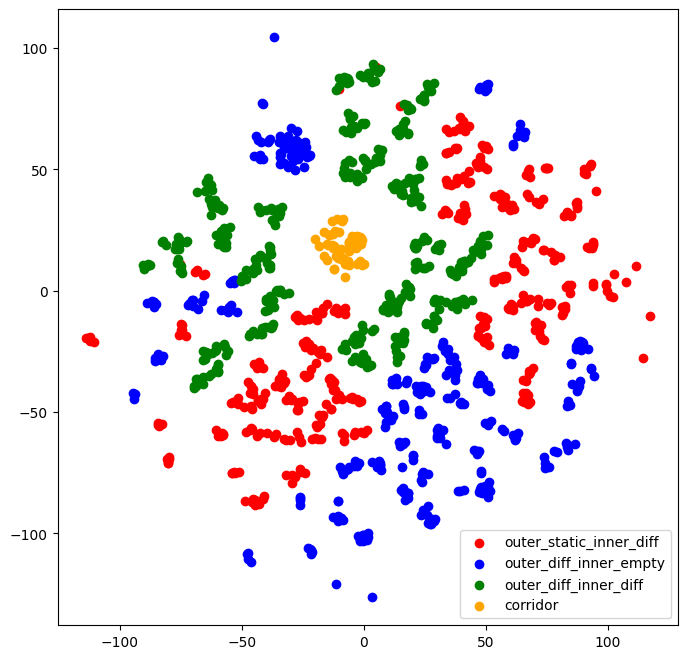

In [125]:
ssd = []
msd = []
pod = []
pad = []

results_dict = {}

pattern_names = ['outer_static_inner_diff', 'outer_diff_inner_empty', 'outer_diff_inner_diff', 'corridor']

for pattern_name in pattern_names:
    model_name = 'default_model_gamma_0_7'
    file_name = 'neurips_test.hdf5'
    results_dict[pattern_name] = {}

    datadir = model_name + '/embeddings' 

    try:
        dataset.close()
    except:
        pass

    print(datadir + '/' + file_name)
    dataset = h5py.File(datadir + '/' + file_name, "r")
    dataset_keys = []
    dataset.visit(
        lambda key: dataset_keys.append(key)
        if isinstance(dataset[key], h5py.Dataset)
        else None
    )


    num_embeddings = len(dataset['obs'])
    pos_dists = [] 
    multi_step_dists = []
    single_step_dists = []
    embed_dist = [] 
    pattern_dists = []
    count = 0
    norm_orders = [1]


    outer_diffs_single = []
    outer_diffs_multi = []
    inner_diffs_single = []
    inner_diffs_multi = []
    
    dlen = len(dataset['name'])

    labels = [name.decode("utf-8") for name in dataset['name']]
    
    ss_encs = [dataset['ss_enc'][i] for i in range(dlen) if dataset['name'][i].decode("utf-8") == pattern_name]
    ms_encs = [dataset['ms_enc'][i] for i in range(dlen) if dataset['name'][i].decode("utf-8") == pattern_name]
    poss = [dataset['pos'][i] for i in range(dlen) if dataset['name'][i].decode("utf-8") == pattern_name]
    inner_obss = [dataset['inner_obs'][i] for i in range(dlen) if dataset['name'][i].decode("utf-8") == pattern_name]
    obss = [dataset['obs'][i] for i in range(dlen) if dataset['name'][i].decode("utf-8") == pattern_name]
    
    nlen = len(ss_encs)
    
    
    count = 0
    for i in tqdm(range(nlen)):
        for j in range(i+1, nlen):
            
            single_step_dist = distance_measure(ss_encs[i], ss_encs[j], order=2)
            multi_step_dist =  distance_measure(ms_encs[i], ms_encs[j], order=2)

            pos_dist = distance_measure(poss[i], poss[j], order=2)
            pattern_dist = distance_measure(obss[i], obss[j], order=1)
            
            single_step_dists.append(single_step_dist)
            multi_step_dists.append(multi_step_dist)
            pos_dists.append(pos_dist)
            pattern_dists.append(pattern_dist)
                
                
    
                


    results_dict[pattern_name]= {'ssd': single_step_dists,
                                           'msd': multi_step_dists,
                                           'pod': pos_dists,
                                           'pad': pattern_dists,
                                           'obs': np.array(obss[:]),
                                           'ss_enc': ss_encs[:],
                                           'ms_enc': ms_encs[:] }
    
ms_encs = np.array([dataset['ss_enc'][i] for i in range(dlen)])
labels = [dataset['name'][i].decode("utf-8") for i in range(dlen)]
print(ms_encs.shape)
X = ms_encs #np.array(results_dict['outer_diff_inner_empty']['msd'])

X_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=3).fit_transform(X)
X_embedded += np.random.normal(0, 1, size=X_embedded.shape)

mask = np.array([pattern_names.index(pat.decode("utf-8")) for pat in dataset['name']])
colors = ['red', 'blue', 'green', 'orange']
for p in range(len(pattern_names)):
    plt.scatter(X_embedded[mask==p,0], X_embedded[mask==p,1], c = colors[p], label=pattern_names[p])
    plt.legend()
                            

default_model_gamma_0_9/embeddings/neurips_test.hdf5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:02<00:00, 199.18it/s]


default_model_gamma_0_9/embeddings/neurips_test.hdf5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:02<00:00, 197.36it/s]


default_model_gamma_0_9/embeddings/neurips_test.hdf5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:02<00:00, 198.87it/s]


default_model_gamma_0_9/embeddings/neurips_test.hdf5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 544.79it/s]


(1349, 128)


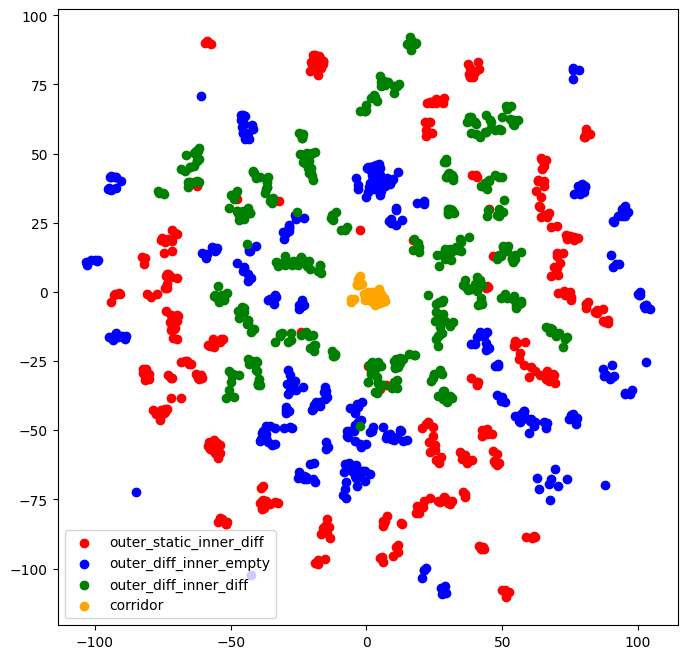

In [126]:
ssd = []
msd = []
pod = []
pad = []

results_dict = {}

pattern_names = ['outer_static_inner_diff', 'outer_diff_inner_empty', 'outer_diff_inner_diff', 'corridor']

for pattern_name in pattern_names:
    model_name = 'default_model_gamma_0_9'
    file_name = 'neurips_test.hdf5'
    results_dict[pattern_name] = {}

    datadir = model_name + '/embeddings' 

    try:
        dataset.close()
    except:
        pass

    print(datadir + '/' + file_name)
    dataset = h5py.File(datadir + '/' + file_name, "r")
    dataset_keys = []
    dataset.visit(
        lambda key: dataset_keys.append(key)
        if isinstance(dataset[key], h5py.Dataset)
        else None
    )


    num_embeddings = len(dataset['obs'])
    pos_dists = [] 
    multi_step_dists = []
    single_step_dists = []
    embed_dist = [] 
    pattern_dists = []
    count = 0
    norm_orders = [1]


    outer_diffs_single = []
    outer_diffs_multi = []
    inner_diffs_single = []
    inner_diffs_multi = []
    
    dlen = len(dataset['name'])

    labels = [name.decode("utf-8") for name in dataset['name']]
    
    ss_encs = [dataset['ss_enc'][i] for i in range(dlen) if dataset['name'][i].decode("utf-8") == pattern_name]
    ms_encs = [dataset['ms_enc'][i] for i in range(dlen) if dataset['name'][i].decode("utf-8") == pattern_name]
    poss = [dataset['pos'][i] for i in range(dlen) if dataset['name'][i].decode("utf-8") == pattern_name]
    inner_obss = [dataset['inner_obs'][i] for i in range(dlen) if dataset['name'][i].decode("utf-8") == pattern_name]
    obss = [dataset['obs'][i] for i in range(dlen) if dataset['name'][i].decode("utf-8") == pattern_name]
    
    nlen = len(ss_encs)
    
    
    count = 0
    for i in tqdm(range(nlen)):
        for j in range(i+1, nlen):
            
            single_step_dist = distance_measure(ss_encs[i], ss_encs[j], order=2)
            multi_step_dist =  distance_measure(ms_encs[i], ms_encs[j], order=2)

            pos_dist = distance_measure(poss[i], poss[j], order=2)
            pattern_dist = distance_measure(obss[i], obss[j], order=1)
            
            single_step_dists.append(single_step_dist)
            multi_step_dists.append(multi_step_dist)
            pos_dists.append(pos_dist)
            pattern_dists.append(pattern_dist)
                
                
    
                


    results_dict[pattern_name]= {'ssd': single_step_dists,
                                           'msd': multi_step_dists,
                                           'pod': pos_dists,
                                           'pad': pattern_dists,
                                           'obs': np.array(obss[:]),
                                           'ss_enc': ss_encs[:],
                                           'ms_enc': ms_encs[:] }
    
ms_encs = np.array([dataset['ss_enc'][i] for i in range(dlen)])
labels = [dataset['name'][i].decode("utf-8") for i in range(dlen)]
print(ms_encs.shape)
X = ms_encs #np.array(results_dict['outer_diff_inner_empty']['msd'])

X_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=3).fit_transform(X)
X_embedded += np.random.normal(0, 1, size=X_embedded.shape)

mask = np.array([pattern_names.index(pat.decode("utf-8")) for pat in dataset['name']])
colors = ['red', 'blue', 'green', 'orange']
for p in range(len(pattern_names)):
    plt.scatter(X_embedded[mask==p,0], X_embedded[mask==p,1], c = colors[p], label=pattern_names[p])
    plt.legend()
                            

default_model_gamma_0_5/embeddings/neurips_test.hdf5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:02<00:00, 199.04it/s]


default_model_gamma_0_5/embeddings/neurips_test.hdf5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:02<00:00, 198.47it/s]


default_model_gamma_0_5/embeddings/neurips_test.hdf5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:02<00:00, 197.09it/s]


default_model_gamma_0_5/embeddings/neurips_test.hdf5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 184/184 [00:00<00:00, 435.46it/s]


(1384, 128)


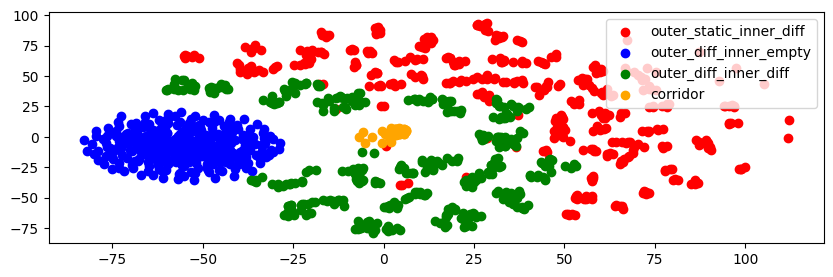

In [133]:
ssd = []
msd = []
pod = []
pad = []

results_dict = {}

pattern_names = ['outer_static_inner_diff', 'outer_diff_inner_empty', 'outer_diff_inner_diff', 'corridor']

for pattern_name in pattern_names:
    model_name = 'default_model_gamma_0_5'
    file_name = 'neurips_test.hdf5'
    results_dict[pattern_name] = {}

    datadir = model_name + '/embeddings' 

    try:
        dataset.close()
    except:
        pass

    print(datadir + '/' + file_name)
    dataset = h5py.File(datadir + '/' + file_name, "r")
    dataset_keys = []
    dataset.visit(
        lambda key: dataset_keys.append(key)
        if isinstance(dataset[key], h5py.Dataset)
        else None
    )


    num_embeddings = len(dataset['obs'])
    pos_dists = [] 
    multi_step_dists = []
    single_step_dists = []
    embed_dist = [] 
    pattern_dists = []
    count = 0
    norm_orders = [1]


    outer_diffs_single = []
    outer_diffs_multi = []
    inner_diffs_single = []
    inner_diffs_multi = []
    
    dlen = len(dataset['name'])

    labels = [name.decode("utf-8") for name in dataset['name']]
    
    ss_encs = [dataset['ss_enc'][i] for i in range(dlen) if dataset['name'][i].decode("utf-8") == pattern_name]
    ms_encs = [dataset['ms_enc'][i] for i in range(dlen) if dataset['name'][i].decode("utf-8") == pattern_name]
    poss = [dataset['pos'][i] for i in range(dlen) if dataset['name'][i].decode("utf-8") == pattern_name]
    inner_obss = [dataset['inner_obs'][i] for i in range(dlen) if dataset['name'][i].decode("utf-8") == pattern_name]
    obss = [dataset['obs'][i] for i in range(dlen) if dataset['name'][i].decode("utf-8") == pattern_name]
    
    nlen = len(ss_encs)
    
    
    count = 0
    for i in tqdm(range(nlen)):
        for j in range(i+1, nlen):
            
            single_step_dist = distance_measure(ss_encs[i], ss_encs[j], order=2)
            multi_step_dist =  distance_measure(ms_encs[i], ms_encs[j], order=2)

            pos_dist = distance_measure(poss[i], poss[j], order=2)
            pattern_dist = distance_measure(obss[i], obss[j], order=1)
            
            single_step_dists.append(single_step_dist)
            multi_step_dists.append(multi_step_dist)
            pos_dists.append(pos_dist)
            pattern_dists.append(pattern_dist)
                
                
    
                


    results_dict[pattern_name]= {'ssd': single_step_dists,
                                           'msd': multi_step_dists,
                                           'pod': pos_dists,
                                           'pad': pattern_dists,
                                           'obs': np.array(obss[:]),
                                           'ss_enc': ss_encs[:],
                                           'ms_enc': ms_encs[:] }
    
ms_encs = np.array([dataset['ss_enc'][i] for i in range(dlen)])
labels = [dataset['name'][i].decode("utf-8") for i in range(dlen)]
print(ms_encs.shape)
X = ms_encs #np.array(results_dict['outer_diff_inner_empty']['msd'])

X_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=3).fit_transform(X)
X_embedded += np.random.normal(0, 1, size=X_embedded.shape)

mask = np.array([pattern_names.index(pat.decode("utf-8")) for pat in dataset['name']])
colors = ['red', 'blue', 'green', 'orange']
for p in range(len(pattern_names)):
    plt.scatter(X_embedded[mask==p,0], X_embedded[mask==p,1], c = colors[p], label=pattern_names[p])
    plt.legend()
                            

In [25]:
ssd = []
msd = []
pod = []
pad = []

model_name = 'default_model_gamma_0_5'
file_name = 'size_vary.hdf5'


datadir = model_name + '/embeddings' 

try:
    dataset.close()
except:
    pass

print(datadir + '/' + file_name)
dataset = h5py.File(datadir + '/' + file_name, "r")
dataset_keys = []
dataset.visit(
    lambda key: dataset_keys.append(key)
    if isinstance(dataset[key], h5py.Dataset)
    else None
)

pattern_names = [name.decode("utf-8") for name in list(set(dataset['name']))]
pattern_names = pattern_names
labels = [name.decode("utf-8") for name in dataset['name']]
print(pattern_names)

results_dict = {}

# pattern_names = ['outer_static_inner_diff', 'outer_diff_inner_empty', 'outer_diff_inner_diff', 'corridor']

for pattern_name in pattern_names:


    num_embeddings = len(dataset['obs'])
    pos_dists = [] 
    multi_step_dists = []
    single_step_dists = []
    embed_dist = [] 
    pattern_dists = []
    count = 0
    norm_orders = [1]


    outer_diffs_single = []
    outer_diffs_multi = []
    inner_diffs_single = []
    inner_diffs_multi = []
    
    dlen = len(dataset['name'])
    
    ss_encs = [dataset['ss_enc'][i] for i in range(dlen) if dataset['name'][i].decode("utf-8") == pattern_name]
    ms_encs = [dataset['ms_enc'][i] for i in range(dlen) if dataset['name'][i].decode("utf-8") == pattern_name]
    poss = [dataset['pos'][i] for i in range(dlen) if dataset['name'][i].decode("utf-8") == pattern_name]
    inner_obss = [dataset['inner_obs'][i] for i in range(dlen) if dataset['name'][i].decode("utf-8") == pattern_name]
    obss = [dataset['obs'][i] for i in range(dlen) if dataset['name'][i].decode("utf-8") == pattern_name]
    
    nlen = len(ss_encs)
    
    
    count = 0
    for i in tqdm(range(nlen)):
        for j in range(i+1, nlen):
            
            single_step_dist = distance_measure(ss_encs[i], ss_encs[j], order=2)
            multi_step_dist =  distance_measure(ms_encs[i], ms_encs[j], order=2)

            pos_dist = distance_measure(poss[i], poss[j], order=2)
            pattern_dist = distance_measure(obss[i], obss[j], order=1)
            
            single_step_dists.append(single_step_dist)
            multi_step_dists.append(multi_step_dist)
            pos_dists.append(pos_dist)
            pattern_dists.append(pattern_dist)
                
                
    
                


    results_dict[pattern_name]= {'ssd': single_step_dists,
                                           'msd': multi_step_dists,
                                           'pod': pos_dists,
                                           'pad': pattern_dists,
                                           'obs': np.array(obss[:]),
                                           'ss_enc': ss_encs[:],
                                           'ms_enc': ms_encs[:] }
    
ms_encs = np.array([dataset['ss_enc'][i] for i in range(dlen)])
labels = [dataset['name'][i].decode("utf-8") for i in range(dlen)]

X = ms_encs #np.array(results_dict['outer_diff_inner_empty']['msd'])

X_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=3).fit_transform(X)
X_embedded += np.random.normal(0, 1, size=X_embedded.shape)

mask = np.array([pattern_names.index(pat.decode("utf-8")) for pat in dataset['name']])
total_colors =  list(mcolors.CSS4_COLORS)
colors = random.choise(total_colors, k=len(pattern_names))

for p in range(len(pattern_names)):
    plt.scatter(X_embedded[mask==p,0], X_embedded[mask==p,1], c = colors[p], label=pattern_names[p])
    plt.legend()
dataset.close()

default_model_gamma_0_5/embeddings/size_vary.hdf5
['inner_static_outer_diff_7', 'inner_diff_outer_static_7', 'inner_static_outer_diff_3', 'inner_diff_outer_static_3', 'inner_diff_outer_static_5', 'inner_static_outer_diff_5']


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:02<00:00, 193.66it/s]


NameError: name 'mcolors' is not defined